# Laugh test 5: Water movement through snow - countour plot
This notebook plots SUMMA simulations for the test case defined in in Clobeck (1976) and further developed in Clark et al. (2017).

## Expectations
The simulations are compared to analytical solutions.

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  | See attributes in output .nc file |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | R. Zolfaghari |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

Clark, M. P., B. Nijssen, and C. H. Luce (2017), An analytical test case for snow models, Water Resour. Res., 53, 909–
922, doi:10.1002/2016WR019672.

Colbeck, S., and E. A. Anderson (1982), The permeability of a melting snow cover, Water Resour. Res., 18(4), 904–908, doi:10.1029/WR012i003p00523

In [1]:
# modules
from pathlib import Path
from matplotlib.ticker import MultipleLocator
import xarray as xr # note, also needs netcdf4 library installed
import matplotlib.pyplot as plt
import numpy as np
import sys

## Analytical solution

In [2]:
# Define constants
gravity      =       9.80616  # acceleration of gravity              (m s-2)
Cp_air       =    1005        # specific heat of air                 (J kg-1 K-1)
Cp_ice       =    2114        # specific heat of ice                 (J kg-1 K-1)
Cp_soil      =     850        # specific heat of soil                (J kg-1 K-1)
Cp_water     =    4181        # specific heat of liquid water        (J kg-1 K-1)
dynVisc      =       0.001781 # dynamic viscosity of water           (kg m-1 s-1)
Tfreeze      =     273.16     # temperature at freezing              (K)
LH_fus       =  333700        # latent heat of fusion                (J kg-1)
LH_vap       = 2501000        # latent heat of vaporization          (J kg-1)
LH_sub       = 2834700        # latent heat of sublimation           (J kg-1)
iden_air     =       1.293    # intrinsic density of air             (kg m-3)
iden_ice     =     917        # intrinsic density of ice             (kg m-3)
iden_water   =    1000        # intrinsic density of liquid water    (kg m-3)
secprday     =   86400        # number of seconds in a day
SW_i         =       0.07    # min fraction of pore space filled for flow (-)

In [3]:
# Define domain
depth       =   1   # snow depth (meters)
snowDensity = 300   # snow density (kg m-3)

In [4]:
# Define flux
rainfall  = 10**(-5)    # rainfall (m s-1)
duration  = 10800       # duration of rainfall flux (seconds)
startRain = 0           # start of rainfall

In [5]:
# Define exponent in flux parameterization
n = 3

In [6]:
# Define initial relative water content for the 3 different test cases (ripe, refrozen, fresh snow)
Sw = np.array([0.07, 0, 0])

**Note:** the following calculations are done for the three test cases simultaneously

In [7]:
# Define porosity
porosityVec = (snowDensity - iden_ice) / (iden_water*Sw - iden_ice)
print('porosity = ' + str(porosityVec))

porosity = [0.72845336 0.67284624 0.67284624]


In [8]:
# Define the volumetric fraction of liquid water
volFracLiq = Sw*porosityVec
print('volFracLiq = ' + str(volFracLiq))

volFracLiq = [0.05099174 0.         0.        ]


In [9]:
# Define the volumetric fraction of ice
volFracIce = 1 - porosityVec
print('volFracIce = ' + str(volFracIce))

volFracIce = [0.27154664 0.32715376 0.32715376]


In [10]:
# Compute fraction of liquid water
volFracTot = volFracIce*iden_ice/iden_water + volFracLiq
fracLiquid = volFracLiq/volFracTot
print('fracLiquid = ' + str(fracLiquid))

fracLiquid = [0.16997245 0.         0.        ]


In [11]:
# Compute temperature based on the fraction of liquid water (K)
fc_param = 50 
ripeTemp = Tfreeze - ((1/fracLiquid[0] - 1)/fc_param**2)**(0.5)
print('ripeTemp = ' + str(ripeTemp))
print('\033[1m' + 'NOTE:' + '\033[0m' + ' should we explain why this is only done for ripe snow?')

ripeTemp = 273.11580359145404
NOTE: should we explain why this is only done for ripe snow?


In [12]:
# Refine residual liquid water content
residLiqVec = SW_i*porosityVec
print('residLiqVec' + str(residLiqVec))

residLiqVec[0.05099174 0.04709924 0.04709924]


In [13]:
# Define experiments
expName   = ['Ripe snow', 'Refrozen snow', 'Fresh snow']    # experiment name
grainSize = np.array([ 2.0, 2.0, 0.2]) / 1000               # grain size (m)
snowTemp  = np.array([ripeTemp, -5 + Tfreeze, -5 + Tfreeze])# temperature (K)
thetaLiq  = volFracLiq                                      # initial volumetric fraction of liquid water (-)

In [14]:
# auxiliary function 
# ----- compute depth for a given time after the kinematic shock -----
# use bi-section method to compute depth for a given time after the kinematic shock
def getDepth(xTime, timeCenter, timeShock, depthShock, depthTotal, a, b, c, n):

# return value:
# depth of the kinematic shock at time xTime

# inputs:
# xTime      = desired time
# timeCenter = center time of the characteristics, the time that rainfall ends (timeShock > timeEnd)
# timeShock  = time of the kinematic shock (xTime > timeShock)
# depthShock = depth of the kinematic shock
# depthTotal = total depth of snow
# a, b, c    = constants
# n          = exponent

    # define the print flag for progress reports
    print=0  #1 

    # define the number of iterations
    niter = 100

    # define the convergence criteria
    convTol = 0.000001

    # define brackets
    d0 = depthTotal
    d1 = depthShock

    # iterate
    for iter in range(1,niter+1):

        # get midpoint
        depthTrial = 0.5*(d0 + d1)

        # trial solution
        tmp1 = a*(1 - n) - b*((n - 1)/n)*( depthTrial**(n/(n - 1)) - depthShock**(n/(n - 1)) )
        tmp2 = a*(1 - n)*(timeShock - timeCenter)**(1/(1 - n)) + c*(depthTrial - depthShock)
        tt   = (tmp2/tmp1)**(1 - n) + timeCenter

        # function evaluation
        if(abs(tt - xTime) < convTol):
            break
        if(iter == niter): 
            sys.exit('Error: convergence problem in getDepth -- maximum iterations reached')

        # print
        if(print):
            print('iter, d0, d1, depthTrial, tt, xTime = %f, %f, %f, %f, %f, %f' % (iter, d0, d1, depthTrial, tt, xTime))

        # update bounds
        if(xTime < tt): 
            d0=depthTrial
        if(xTime > tt): 
            d1=depthTrial

    return depthTrial

In [15]:
# Loop through experiments
for iExp in range(0,3):

    # Enable/disable prints for the analytical solution
    printFlag = 0
    
    # print the experiment name
    if printFlag: print(expName[iExp])

    # get porosity and residual liquid water content
    porosity = porosityVec[iExp]
    residLiq = residLiqVec[iExp]
    
    # ----- Calculate variables -----
    # compute hydraulic conductivity (m s-1)
    permeability = grainSize[iExp]**2 * 0.077*np.exp(-7.8*snowDensity/iden_water)  # permeability (m2)
    conductivity = permeability*iden_water*gravity/dynVisc                      # hydraulic conductivity (m s-1)
    if printFlag: print('ratio           = ', str(permeability/grainSize[iExp]**2))
    if printFlag: print('grainsize^2     = ', str(grainSize[iExp]**2))
    if printFlag: print('permeability    = ', str(permeability))
    if printFlag: print('conductivity    = ', str(conductivity))
    
    # define the volumetric fraction of water required to maintain the speed of the wetting front
    satRequire   = (rainfall/conductivity)**(1/n)
    thetaRequire = residLiq + satRequire*(porosity - residLiq) - thetaLiq[iExp]
    if printFlag: print('residLiq        = ' + str(residLiq))
    if printFlag: print('porosity        = ' + str(porosity))
    if printFlag: print('satRequire      = ' + str(satRequire))
    if printFlag: print('thetaRequire    = ' + str(thetaRequire))
    
    # define the level of saturation necessary to satisfy thermal requirements
    heatRequire = (snowTemp[iExp] - Tfreeze)*(porosity - 1) * iden_ice*Cp_ice/(iden_water*LH_fus)
    if printFlag: print('heatRequire     = ' + str(heatRequire))
    
    # compute the time required for the wetting front to reach the bottom of the snowpack
    watRequire      = depth*(thetaRequire + heatRequire)  # water required so the entire profile = thetaRequire (m)
    timeWetting     = watRequire/rainfall
    celerityWetting = depth/timeWetting
    if printFlag: print('watRequire      = ' + str(watRequire))
    if printFlag: print('timeWetting     = ' + str(timeWetting))
    if printFlag: print('timeWetting (h) = ' + str(timeWetting/3600))
    if printFlag: print('celerityWetting = ' + str(celerityWetting))
    
    # compute the celerity (m s-1)
    celerity = (n/(porosity - residLiq)) * conductivity**(1/n) * rainfall**((n - 1)/n)
    if printFlag: print('celerity        = ' + str(celerity))
    
    # compute the lag time (s)
    timeLag    = depth/celerity
    timeDrying = duration + timeLag
    if printFlag: print('lag time        = ' + str(timeLag))
    
    # ----- Check if kinematic shock occurs -----
    # check if the snowpack reaches steady state
    if (timeWetting < timeDrying):
        
        # no shock exists
        timeShock  = 10 * 3600   # set the shock time to the end of the simulation (10 hours)
        timeBottom = timeWetting # water reaches the bottom of the snowpack at timeWetting
    
    # check if the drying front overtakes the wetting front (kinematic shock)
    else:
    
        # define the depth of the kinematic shock (the depth that the lines intersect)
        # time is equal, so: depth/celerityWetting + startRain = depth/celerity + duration
        # then: depth/celerityWetting - depth/celerity = duration - startRain
        # so
        depthShock = (duration - startRain) / (1/celerityWetting - 1/celerity)
        if printFlag: print('depthShock = ' + str(depthShock))
        
        # get the time when the wetting front stops propagating at its maximum value
        timeShock  = depthShock/celerity + duration
        if printFlag: print('timeShock  = ' + str(timeShock/3600))
        
        # define short-cut variables
        a = conductivity*(depthShock*(porosity - residLiq)/(n*conductivity))**(n/(n - 1))
        b = (porosity - residLiq)*( ((porosity - residLiq)/(n*conductivity))**(1/(n - 1)) )
        c = residLiq + heatRequire
        
        # time that shock reaches the bottom of the snowpack
        tmp1       = a*(1 - n) - b*((n - 1)/n)*( depth**(n/(n - 1)) - depthShock**(n/(n - 1)) )
        tmp2       = a*(1 - n)*(timeShock - duration)**(1/(1 - n)) + c*(depth - depthShock)
        tb         = (tmp2/tmp1)**(1 - n)
        timeBottom = tb + duration
        if printFlag: print('tb = ' + str(tb + duration))
        if printFlag: print('tb (hours) = ' + str((tb + duration)/3600))
    
    # ----- COMPUTE ANALYTICAL SOLUTIONS FOR THE TIME SERIES OF VOLUMETRIC LIQUID WATER PROFILE -----
    # define the volumetric liquid water profile for multiple times
    nTime = 60*10    # every minute for 10 hours
    xTime = 3600*10*(np.arange(nTime)+1)/nTime  # time in seconds
    #print('xTime = ' + str(xTime))
    
    # define depths
    nDepth  = 100
    yDepth  = depth*(np.arange(nDepth)+0.5)/nDepth
    yHeight = depth*(np.arange(nDepth+1))/nDepth
    #print('yDepth = ' + str(yDepth))
    #print('yHeight = ' + str(yHeight))
    
    # define an array for the solution
    volFracLiq = np.empty([nDepth,nTime])
    
    # loop through times
    for iTime in range(0,nTime):  #IDL: for iTime=0,nTime-1 do begin
        
        # identify specific cases
        # case 1: wetting front while rain is still falling
        if (xTime[iTime] < timeWetting) and (xTime[iTime] < duration): 
            depthWetting = (xTime[iTime] - startRain)*celerityWetting
            depthDrying  = 0
   
        # case 2: wetting front while rain is still falling
        elif (xTime[iTime] >= timeWetting) and (xTime[iTime] < duration):
            depthWetting = depth 
            depthDrying  = 0

        # case 3: drying front above wetting front
        elif (xTime[iTime] >= duration) and (xTime[iTime] < min([timeShock,timeDrying])):
            depthWetting = (xTime[iTime] - startRain)*celerityWetting
            depthDrying  = (xTime[iTime] - duration)*celerity

        # case 4: propagation of the kinematic shock
        elif (xTime[iTime] >= timeShock) and (xTime[iTime] < timeBottom):
            depthWetting = getDepth(xTime[iTime], duration, timeShock, depthShock, depth, a, b, c, n)
            depthDrying  = depthWetting
   
        # case 5: water reached the bottom of the snowpack
        elif (xTime[iTime] >= timeBottom) and (xTime[iTime] >= duration): 
            depthWetting = depth
            depthDrying  = depth

        # check that we found everything
        else: 
            print('Error: could not find case')
            break
        
        # define areas of the snowpack
        iDry = np.where(yDepth > depthWetting)                             # no change from intial state
        iSat = np.where((yDepth <= depthWetting) & (yDepth > depthDrying)) # maximum possible wetting
        iMid = np.where(yDepth < depthDrying)                              # drying phase

        # check whether we've found the state for each defined depth
        nDry = len(iDry[0])
        nSat = len(iSat[0])
        nMid = len(iMid[0])
        if(nDry+nSat+nMid != nDepth):
            print(nDry + nSat + nMid)
            print(nDepth)
            print('Error: problem identifying different areas of the snowpack')
            break
        
        # define volumetric fraction of liquid water
        if(nDry > 0):
            volFracLiq[iDry,iTime] = thetaLiq[iExp]                # initial state
        if(nSat > 0):
            volFracLiq[iSat,iTime] = thetaRequire + thetaLiq[iExp] # maximum possible wetting
        if(nMid > 0):
            satProfile             = ( (porosity - residLiq)*yDepth[iMid]/(n*conductivity*(xTime[iTime] - duration)) )**(1/(n - 1))
            volFracLiq[iMid,iTime] = residLiq + (porosity - residLiq)*satProfile
    
    # ----- store the results in specific variables for plotting -----
    if iExp == 0:   volFraqLiq_analytical_exp1 = volFracLiq
    elif iExp == 1: volFraqLiq_analytical_exp2 = volFracLiq
    elif iExp == 2: volFraqLiq_analytical_exp3 = volFracLiq
    
    # ----- end of experiment -----
    if printFlag: print('\n')   

## Numerical results

In [16]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_file = ['colbeck1976-exp1_output_timestep.nc', 'colbeck1976-exp2_output_timestep.nc', 'colbeck1976-exp3_output_timestep.nc']

In [17]:
# Define the sub-selection to extract
hru_idx = 0 # there's only 1 HRU but this turns a 3D dataframe into 2D, which is easier with plotting
lay_idx = np.arange(0,100) # there are 120 snow layers in the numerical simulations, but only layers up till depth = 1m are needed

In [18]:
# Loop through the experiments and extract the data
for iExp in range(0,3):
    
    # Load the .nc file
    ds = xr.open_dataset( sim_path / sim_file[iExp] )

    # Extract the variable of interest
    mLayerVolFracLiq = ds.mLayerVolFracLiq
    
    # Store in temporary variables
    if iExp == 0:   volFraqLiq_numerical_exp1 = mLayerVolFracLiq.isel(midToto=lay_idx,hru=hru_idx)
    elif iExp == 1: volFraqLiq_numerical_exp2 = mLayerVolFracLiq.isel(midToto=lay_idx,hru=hru_idx)
    elif iExp == 2: volFraqLiq_numerical_exp3 = mLayerVolFracLiq.isel(midToto=lay_idx,hru=hru_idx)

## Plotting

In [19]:
# Ensure that we can actually read the figure labels
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font);

In [20]:
# Specify some figure-wide settings
plt.set_cmap('jet');         # Choose a colormap
cmin, cmax = 0,0.2          # Color limits

<Figure size 432x288 with 0 Axes>

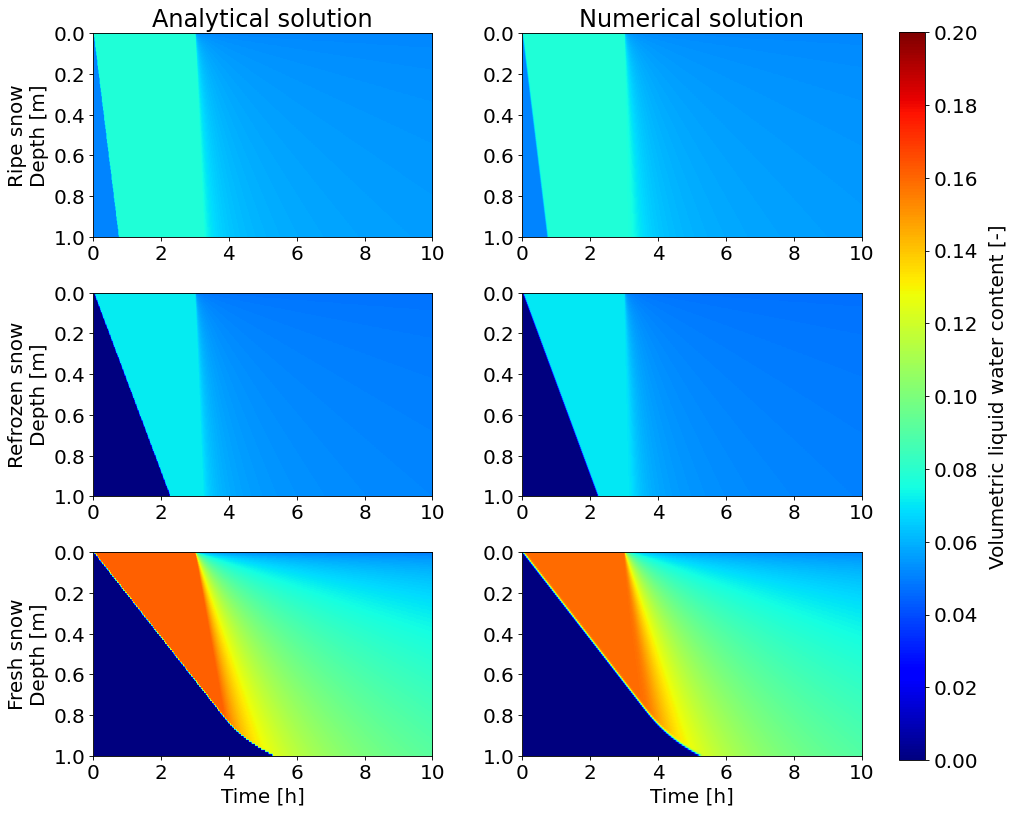

In [21]:
# Open a figure
fig, ax = plt.subplots(3,2, figsize=(11, 10), dpi= 80, facecolor='w', edgecolor='k');
fig.tight_layout()          # Switch to more spacious layout

# Plot the three analytical and numerical results for each of the three experiments
for iExp in range(0,3):
    
    # Get the data
    if iExp == 0:   
        volFracLiq_a = volFraqLiq_analytical_exp1
        volFracLiq_n = volFraqLiq_numerical_exp1        
    elif iExp == 1: 
        volFracLiq_a = volFraqLiq_analytical_exp2
        volFracLiq_n = volFraqLiq_numerical_exp2
    elif iExp == 2: 
        volFracLiq_a = volFraqLiq_analytical_exp3
        volFracLiq_n = volFraqLiq_numerical_exp3
        
    # plot the results
    im = ax[iExp,0].imshow(volFracLiq_a, \
                           aspect='auto', \
                           extent=[xTime[0]/3600,xTime[-1]/3600,yHeight[-1],yHeight[0]], \
                           vmin=cmin, vmax=cmax)
    im = ax[iExp,1].imshow(volFracLiq_n.transpose(), \
                           aspect='auto', \
                           extent=[xTime[0]/3600,xTime[-1]/3600,yHeight[-1],yHeight[0]], \
                           vmin=cmin, vmax=cmax)
    
    # Axes
    ax[iExp,0].set_xticks(np.arange(0,10.01,2))
    ax[iExp,1].set_xticks(np.arange(0,10.01,2))
    
    # Label etc
    ax[0,0].set_title('Analytical solution')
    ax[0,1].set_title('Numerical solution')
    ax[2,0].set_xlabel('Time [h]')
    ax[2,1].set_xlabel('Time [h]')
    ax[iExp,0].set_ylabel(expName[iExp] + '\nDepth [m]')

# make a colorbar
cbar_ax = fig.add_axes([1, 0.055, 0.03, .91])
cbar = fig.colorbar(im, cax=cbar_ax);
cbar.set_ticks(np.arange(0,0.201,0.02))
cbar.set_label('Volumetric liquid water content [-]', labelpad=10)

# save the figure
plt.savefig('img/lt5_colbeck1976_contours.png',bbox_inches = 'tight');